In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.layers.merge import concatenate
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.layers import Input
from sklearn.model_selection import KFold
from keras.layers.pooling import AveragePooling1D
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Convolution1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.initializers import random_uniform
from keras.layers import LSTM
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [109]:
df_TFIDF40 = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TFIDF_40.csv') # loading updated csv
df_TFIDF40.rename(columns={'Label': 'ICD9'}, inplace=True)
df_TM5 = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TM_5.csv')
df_TM20 = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TM_20.csv')
df_TM30 = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TM_30.csv')
df_TM30.rename(columns={'top_icd': 'ICD9'}, inplace=True)
df_TM39 = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TM_39.csv')

df_list = [df_TFIDF40, df_TM5, df_TM20, df_TM30, df_TM39]
files_list = ['TFIDF_40', 'TM_5', 'TM_20', 'TM_30', 'TM_39']

In [110]:
df_TFIDF40_old = pd.read_csv('/content/drive/MyDrive/Experiments HealthML CNN/input_ICD9_TFIDF_40.csv')

In [111]:
df_TM20.head(4)

,ICD9,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19
0,424,0.075826,0.035514,0.093239,0.038146,0.015947,0.113980,0.053861,0.027136,0.028813,0.107879,0.038639,0.068352,0.103821,0.000000,0.026953,0.0,0.019094,0.114964,0.012817,0.015217
1,410,0.000000,0.018039,0.016154,0.017364,0.000000,0.015514,0.000000,0.227861,0.018801,0.000000,0.013507,0.262186,0.000000,0.000000,0.000000,0.0,0.059638,0.086761,0.186939,0.048626
2,414,0.000000,0.000000,0.026252,0.031915,0.032926,0.095679,0.011797,0.014570,0.142651,0.010267,0.115032,0.160490,0.000000,0.000000,0.000000,0.0,0.000000,0.015606,0.305903,0.014871
3,410,0.000000,0.020312,0.010860,0.057352,0.037957,0.042617,0.040979,0.078233,0.110078,0.028450,0.000000,0.312919,0.032175,0.023174,0.000000,0.0,0.039586,0.038681,0.096131,0.012925


In [112]:
print([True for df in df_list if 'ICD9' in df.columns])
print([df.shape for df in df_list]) # correct shapes

[True, True, True, True, True]
[(5936, 41), (11537, 6), (11537, 21), (11537, 31), (11537, 40)]


In [113]:
def get_data(df:pd.DataFrame):
 
  ICD9_CODE_map = {
    '414': 0, #chronic heart
    '38':  1, #sepsis
    '410': 2, #heart attack
    '424': 3, #diseases of endocardium
    }
  Y = df.ICD9
  X = df.drop(columns=['ICD9'])
  Y = Y.map({414:0, 38: 1, 410:2, 424: 3})
  Y = to_categorical(Y, 4)
  X = X.values.astype('float')
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state = 42, shuffle=True) 
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, Y_train, Y_test

In [114]:
# # Original works well with all TMs
def cnn(df:pd.DataFrame, DataName: str):
	print(DataName, ":", df.shape)
	X_train, X_test, Y_train, Y_test = get_data(df)
	model = Sequential()
	model.add(Conv1D(32, 3, activation='relu', input_shape = (X_train.shape[1],1)))
	model.add(BatchNormalization()) 
	model.add(Dropout(0.5)) 
	model.add(MaxPooling1D(2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(4, activation='softmax'))
	model.compile(loss="categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])
 
	history = model.fit(X_train, Y_train,validation_split=0.25, epochs = 25, batch_size=32, shuffle=True, verbose=1)  
	predictions = model.predict(X_test)
	Y_pred = predictions.argmax(axis=1)
	Y_test_max = Y_test.argmax(axis=1)
	bal_acc = balanced_accuracy_score(Y_test_max, Y_pred)
	f1 = f1_score(Y_test_max, Y_pred, average='weighted')
	auc = roc_auc_score(Y_test_max, predictions, multi_class='ovr', average='macro')
	results = dict()
	results['bal_acc'] = bal_acc
	results['f1'] = f1
	results['auc'] = auc

	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('Model Accuracy for %s' % DataName)
	plt.ylabel('Accuracy')
	plt.xlabel('Epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('Model loss for %s' % DataName)
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	return results

In [115]:
lst = ['TFIDF_40', 'TM_5', 'TM_20', 'TM_30', 'TM_39']

TFIDF_40 : (5936, 41)
Epoch 1/25
94/94 [==============================] - 2s 9ms/step - loss: 0.7288 - accuracy: 0.7254 - val_loss: 1.2204 - val_accuracy: 0.4804
Epoch 2/25
94/94 [==============================] - 1s 7ms/step - loss: 0.5512 - accuracy: 0.7948 - val_loss: 1.1034 - val_accuracy: 0.6925
Epoch 3/25
94/94 [==============================] - 1s 6ms/step - loss: 0.5218 - accuracy: 0.7948 - val_loss: 0.9806 - val_accuracy: 0.7889
Epoch 4/25
94/94 [==============================] - 1s 7ms/step - loss: 0.5035 - accuracy: 0.8032 - val_loss: 0.8454 - val_accuracy: 0.8131
Epoch 5/25
94/94 [==============================] - 1s 7ms/step - loss: 0.4861 - accuracy: 0.8169 - val_loss: 0.6795 - val_accuracy: 0.8201
Epoch 6/25
94/94 [==============================] - 1s 7ms/step - loss: 0.4800 - accuracy: 0.8122 - val_loss: 0.5516 - val_accuracy: 0.8241
Epoch 7/25
94/94 [==============================] - 1s 6ms/step - loss: 0.4692 - accuracy: 0.8122 - val_loss: 0.5412 - val_accuracy: 0.820

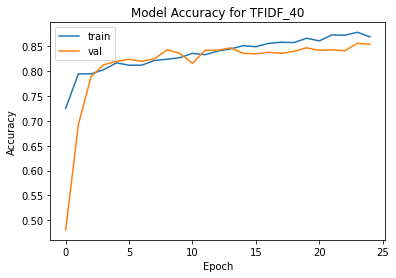

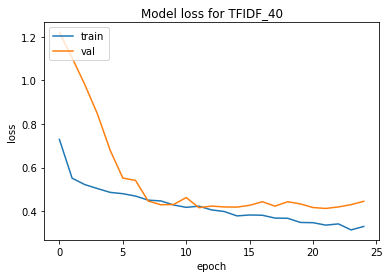

TM_5 : (11537, 6)
Epoch 1/25
182/182 [==============================] - 2s 7ms/step - loss: 0.9531 - accuracy: 0.5989 - val_loss: 1.1054 - val_accuracy: 0.5970
Epoch 2/25
182/182 [==============================] - 1s 6ms/step - loss: 0.7852 - accuracy: 0.6508 - val_loss: 0.8935 - val_accuracy: 0.6513
Epoch 3/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7663 - accuracy: 0.6567 - val_loss: 0.7696 - val_accuracy: 0.6668
Epoch 4/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7554 - accuracy: 0.6703 - val_loss: 0.7462 - val_accuracy: 0.6756
Epoch 5/25
182/182 [==============================] - 1s 6ms/step - loss: 0.7622 - accuracy: 0.6632 - val_loss: 0.7391 - val_accuracy: 0.6756
Epoch 6/25
182/182 [==============================] - 1s 6ms/step - loss: 0.7535 - accuracy: 0.6632 - val_loss: 0.7310 - val_accuracy: 0.6674
Epoch 7/25
182/182 [==============================] - 1s 6ms/step - loss: 0.7501 - accuracy: 0.6667 - val_loss: 0.7453 - val_accur

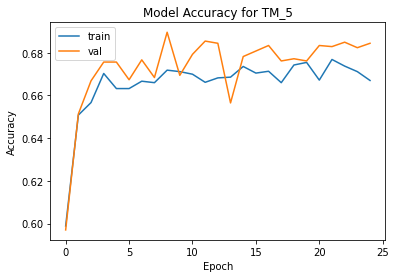

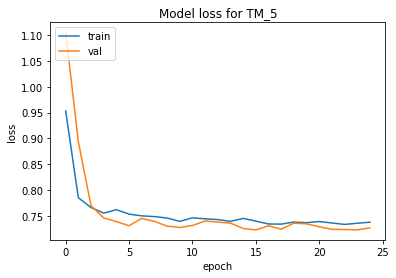

TM_20 : (11537, 21)
Epoch 1/25
182/182 [==============================] - 2s 7ms/step - loss: 0.8288 - accuracy: 0.6591 - val_loss: 1.2290 - val_accuracy: 0.6596
Epoch 2/25
182/182 [==============================] - 1s 6ms/step - loss: 0.7157 - accuracy: 0.7074 - val_loss: 1.0502 - val_accuracy: 0.7108
Epoch 3/25
182/182 [==============================] - 1s 6ms/step - loss: 0.6957 - accuracy: 0.7160 - val_loss: 0.7706 - val_accuracy: 0.7175
Epoch 4/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6872 - accuracy: 0.7212 - val_loss: 0.6796 - val_accuracy: 0.7237
Epoch 5/25
182/182 [==============================] - 1s 6ms/step - loss: 0.6846 - accuracy: 0.7222 - val_loss: 0.6619 - val_accuracy: 0.7258
Epoch 6/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6678 - accuracy: 0.7257 - val_loss: 0.6827 - val_accuracy: 0.7186
Epoch 7/25
182/182 [==============================] - 1s 6ms/step - loss: 0.6683 - accuracy: 0.7276 - val_loss: 0.6792 - val_acc

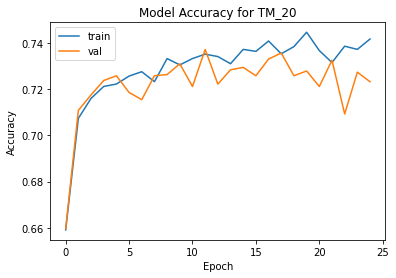

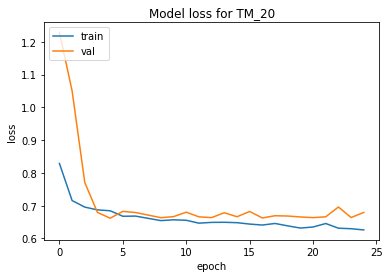

TM_30 : (11537, 31)
Epoch 1/25
182/182 [==============================] - 2s 9ms/step - loss: 0.8006 - accuracy: 0.6701 - val_loss: 1.2538 - val_accuracy: 0.3663
Epoch 2/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6900 - accuracy: 0.7174 - val_loss: 0.9960 - val_accuracy: 0.7155
Epoch 3/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6815 - accuracy: 0.7208 - val_loss: 0.7540 - val_accuracy: 0.7263
Epoch 4/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6752 - accuracy: 0.7220 - val_loss: 0.6563 - val_accuracy: 0.7356
Epoch 5/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6666 - accuracy: 0.7229 - val_loss: 0.6702 - val_accuracy: 0.7212
Epoch 6/25
182/182 [==============================] - 1s 6ms/step - loss: 0.6693 - accuracy: 0.7250 - val_loss: 0.6575 - val_accuracy: 0.7305
Epoch 7/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6545 - accuracy: 0.7369 - val_loss: 0.6395 - val_acc

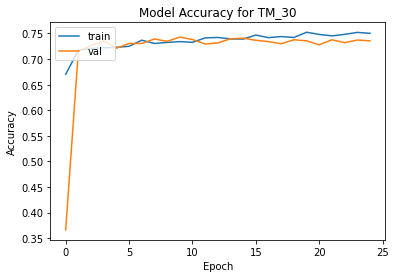

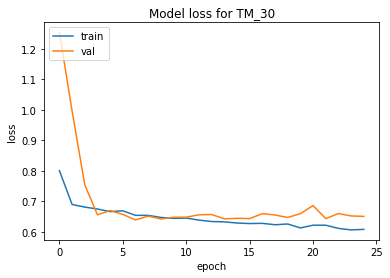

TM_39 : (11537, 40)
Epoch 1/25
182/182 [==============================] - 2s 9ms/step - loss: 0.8169 - accuracy: 0.6706 - val_loss: 1.2679 - val_accuracy: 0.3176
Epoch 2/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7163 - accuracy: 0.7045 - val_loss: 1.0364 - val_accuracy: 0.6436
Epoch 3/25
182/182 [==============================] - 1s 7ms/step - loss: 0.7019 - accuracy: 0.7112 - val_loss: 0.8015 - val_accuracy: 0.7015
Epoch 4/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6953 - accuracy: 0.7217 - val_loss: 0.6968 - val_accuracy: 0.7201
Epoch 5/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6852 - accuracy: 0.7195 - val_loss: 0.6817 - val_accuracy: 0.7201
Epoch 6/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6800 - accuracy: 0.7286 - val_loss: 0.7070 - val_accuracy: 0.7093
Epoch 7/25
182/182 [==============================] - 1s 7ms/step - loss: 0.6726 - accuracy: 0.7303 - val_loss: 0.6714 - val_acc

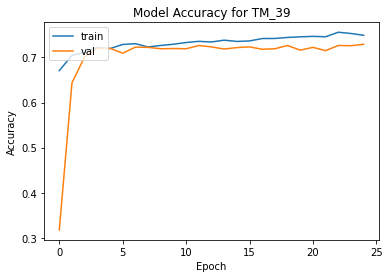

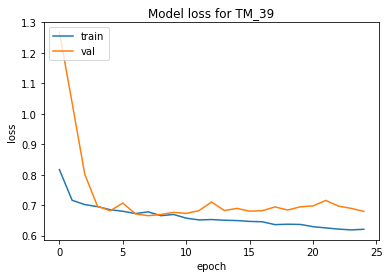

In [116]:
results = [cnn(df, lst[i]) for i, df in enumerate(df_list)]

In [117]:
lst = ['TFIDF_40', 'TM_5', 'TM_20', 'TM_30', 'TM_39']
for i, x in enumerate(results):
  print(lst[i], x)

TFIDF_40 {'bal_acc': 0.8601263552206009, 'f1': 0.8506716858578304, 'auc': 0.9658126022161194}
TM_5 {'bal_acc': 0.6329332196832833, 'f1': 0.6721367647272093, 'auc': 0.8857263068901238}
TM_20 {'bal_acc': 0.7088102472575661, 'f1': 0.7305992328259563, 'auc': 0.9113898630865195}
TM_30 {'bal_acc': 0.7038309394882192, 'f1': 0.7285333029932403, 'auc': 0.9127999590606616}
TM_39 {'bal_acc': 0.6993480181161089, 'f1': 0.7142712192506071, 'auc': 0.9008525774853539}


In [118]:
# TFIDF_40 {'bal_acc': 0.860314212255144, 'f1': 0.8537960170495161, 'auc': 0.967266777906099}
# TM_5 {'bal_acc': 0.6099422478298578, 'f1': 0.649340309252282, 'auc': 0.884170958489013}
# TM_20 {'bal_acc': 0.7188808945859412, 'f1': 0.7265992746214581, 'auc': 0.9104712915043676}
# TM_30 {'bal_acc': 0.6967611716140004, 'f1': 0.725909809572342, 'auc': 0.9126227399439928}
# TM_39 {'bal_acc': 0.6769545618046917, 'f1': 0.7128163974376526, 'auc': 0.9027637889886231}